## Import Libraries

In [1]:
!pip install -U segmentation-models

     |████████████████████████████████| 50 kB 2.9 MB/s  eta 0:00:01


In [2]:
!pip install keras==2.2.4

     |████████████████████████████████| 312 kB 4.7 MB/s eta 0:00:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from kaggle_datasets import KaggleDatasets
import tensorflow as tf

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Convolution2D,Activation,GlobalAveragePooling2D,MaxPooling2D,Flatten,Dense,Dropout,Input,Reshape,Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.models import Model
import math
from keras.callbacks import TensorBoard
import tensorflow.keras.layers as L

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import segmentation_models as sm
from segmentation_models import PSPNet
from segmentation_models.metrics import IOUScore, Precision,Recall
from segmentation_models.losses import JaccardLoss,CategoricalFocalLoss,DiceLoss,CategoricalCELoss
from tensorflow.keras.optimizers import RMSprop

print('Using Segmentation version:', sm.__version__)
print('Using Tensorflow version:', tf.__version__)

Using Segmentation version: 1.0.1
Using Tensorflow version: 2.2.0


In [4]:
sm.framework() 

'keras'

In [5]:
sm.set_framework('tf.keras')

In [6]:
sm.framework() 

'tf.keras'

In our setup, we:
- created a data/ folder
- created CDS folder which contains all folders
- created 4 folders train_frames train_masks val_frames val_masks
- created train and val subfolders inside 4 folders
- put the pictures in data/CDS/train_frames/train/
- put the label pictures in data/train_masks/train/
In summary, this is our directory structure:
```
    data/
        CDS/
            label_colors.txt
            train_frames/
                train/
                    frame1.png # .png format
            train_masks/
                train/
                    frame1_L.png # _L.png format
            val_frames/
                val/
                    frame2.png # .png format
            val_masks/
                val/
                    frame2_L.png # _L.png format
```

In [7]:
def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c
    
def rgb_to_onehot(rgb_image, colormap):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 144 x 144 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int32 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    #print(encoded_image.shape)
    return encoded_image

def onehot_to_rgb(onehot, colormap):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [8]:
def TrainAugmentGenerator(seed = 909, batch_size = 16):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    DATA_PATH + 'train_frames/',
    batch_size = batch_size, seed = seed,target_size=(144,144),shuffle=True)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    DATA_PATH + 'train_masks/',
    batch_size = batch_size, seed = seed,target_size=(144,144),shuffle=True)

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        # Add new for TPU
#         for j in range(X1i[0].shape[0]):
#             X1i[0][j,:,:,:] = tf.cast(X1i[0][j,:,:,:], tf.float32)/255.0
            #print(X1i[0][j,:,:,:])
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        #print(mask_encoded.shape)
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(seed = 909, batch_size = 16):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    DATA_PATH + 'val_frames/',
    batch_size = batch_size, seed = seed,target_size=(144,144),shuffle=False)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    DATA_PATH + 'val_masks/',
    batch_size = batch_size, seed = seed,target_size=(144,144),shuffle=False)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        # Add new for TPU
#         for j in range(X1i[0].shape[0]):
#             X1i[0][j,:,:,:] = tf.cast(X1i[0][j,:,:,:], tf.float32)/255.0
            #print(X1i[0][j,:,:,:])
        #print(X1i[0])
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

Defind variables

In [9]:
img_dir = '../input/goodgame-data/GGDataSet/'

DATA_PATH = '../input/goodgame-data/GGDataSet/'

# Seed defined for aligning images and their masks
train_numbers = len(os.listdir(img_dir + 'train_frames/train/'))

val_numbers = len(os.listdir(img_dir + 'val_frames/val/'))

print('Number of train datasets: ',train_numbers)

print('Number of val datasets: ', val_numbers)

BATCH_SIZE = 64

EPOCHS = 10

label_codes, label_names = zip(*[parse_code(l) for l in open(img_dir+"label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)

print(label_codes, label_names)

Number of train datasets:  3226
Number of val datasets:  806
[(128, 0, 0), (192, 128, 128), (0, 0, 0), (102, 102, 102)] ['Road', 'Line', 'Background', 'Sign']


### Create useful label and code conversion dictionaries
These will be used for:
One hot encoding the mask labels for model training
Decoding the predicted labels for interpretation and visualization


In [10]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

print(id2code,id2name)

{0: (128, 0, 0), 1: (192, 128, 128), 2: (0, 0, 0), 3: (102, 102, 102)} {0: 'Road', 1: 'Line', 2: 'Background', 3: 'Sign'}


### Data Aug

In [11]:
data_gen_args = dict(rotation_range=0.2,
                      width_shift_range=0.05,
                      height_shift_range=0.05,
                      shear_range=0.05,
                      zoom_range=0.05,
                      vertical_flip=True, #can than voi bien bao
                      horizontal_flip=True,
                      fill_mode='nearest',rescale=1./255) # If we use TPU we will use other method to resacle

mask_gen_args = dict(rotation_range=0.2,
                      width_shift_range=0.05,
                      height_shift_range=0.05,
                      shear_range=0.05,
                      zoom_range=0.05,
                      vertical_flip=True, #can than voi bien bao
                      horizontal_flip=True,
                      fill_mode='nearest')

data_gen_args_val = dict(rescale=1./255) # If we use TPU we will use other method to resacle
mask_gen_args_val = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args_val)
val_masks_datagen = ImageDataGenerator(**mask_gen_args_val)

### Calculate Weights

#### Method 1

In [ ]:
import cv2
import os
import numba

@numba.njit(fastmath=True)
def matrix(total_road,total_line,total_background,total_sign,image):
    for j in range(0,480):
        for k in range(0,640):
            b,g,r = image[j][k]
            if (r,g,b) == (128,0,0):
                total_road += 1
            if (r,g,b) == (192,128,128):
                total_line += 1
            if (r,g,b) == (0,0,0):
                total_background +=1
            if (r,g,b) == (102,102,102):
                total_sign += 1
    return total_road,total_line,total_background,total_sign

def calc_weights(masks_folder):
    """Calculate class weights according to classes distribution in a dataset"""
    images_list = os.listdir(masks_folder)
    total_road = 0
    total_line = 0
    total_background = 0
    total_sign = 0
    for i in range(len(images_list)):
        print("Processing ---------",round(i/len(images_list)*100,2),'%\t',i,"/",len(images_list))
        image = cv2.imread(masks_folder + '/' + images_list[i])
        total_road,total_line,total_background,total_sign = matrix(total_road,total_line,total_background,total_sign,image)
        #b,g,r = image[373][145]
        #print(b,g,r)

    total = len(images_list) * 480 * 640
    print("------------------------------------")
    print("Weight of Road: ", total_road / total)
    print("Weight of Line: ", total_line / total)
    print("Weight of BG: ", total_background / total)
    print("Weight of Sign: ", total_sign / total)


img_dir = '../input/goodgame-dataset/GGDataSet/train_masks/train/'

calc_weights(img_dir)

#### Method 2

In [ ]:
import cv2
import os
import numba

@numba.njit(fastmath=True)
def matrix(total_road,total_line,total_background,total_sign,image):
    for j in range(0,480):
        for k in range(0,640):
            b,g,r = image[j][k]
            if (r,g,b) == (128,0,0):
                total_road += 1
            if (r,g,b) == (192,128,128):
                total_line += 1
            if (r,g,b) == (0,0,0):
                total_background +=1
            if (r,g,b) == (102,102,102):
                total_sign += 1
    return total_road,total_line,total_background,total_sign

@numba.njit(fastmath=True)
def cal_contains_object(r_c,g_c,b_c,image):
    for j in range(0,480):
        for k in range(0,640):
            b,g,r = image[j][k]
            if (r,g,b) == (r_c,g_c,b_c):
                return 1
    return 0
def calc_weights(masks_folder):
    """Calculate class weights according to classes distribution in a dataset"""
    global road_global
    global line_global
    global bg_global
    global sign_global    
    
    images_list = os.listdir(masks_folder)
    total_road = 0
    total_line = 0
    total_background = 0
    total_sign = 0
    for i in range(len(images_list)):
        print("Processing ---------",round(i/len(images_list)*100,2),'%\t',i,"/",len(images_list))
        image = cv2.imread(masks_folder + '/' + images_list[i])
        total_road,total_line,total_background,total_sign = matrix(total_road,total_line,total_background,total_sign,image)
        #b,g,r = image[373][145]
        #print(b,g,r)
        road_global += cal_contains_object(128,0,0,image)
        line_global += cal_contains_object(192,128,128,image)
        bg_global += cal_contains_object(0,0,0,image)
        sign_global += cal_contains_object(102,102,102,image)
        
    print("Total of road images: ", road_global)
    print("Total of line images: ", line_global)
    print("Total of background images: ", bg_global)
    print("Total of sign images: ", sign_global)

    road_global = road_global * 640 * 480
    line_global = line_global * 640 * 480
    bg_global = bg_global * 640 * 480
    sign_global = sign_global * 640 * 480

    print("------------------------------------")
    print("Weight of Road: ", total_road / road_global)
    print("Weight of Line: ", total_line / line_global)
    print("Weight of BG: ", total_background / bg_global)
    print("Weight of Sign: ", total_sign / sign_global)

road_global = 0
line_global = 0
bg_global = 0
sign_global = 0

img_dir = '../input/goodgame-data/GGDataSet/train_frames/train'

calc_weights(img_dir)

### Cusom loss

In [49]:
import tensorflow.keras.backend as K

def class_tversky(y_true, y_pred):
    smooth = 1

    y_true = K.permute_dimensions(y_true, (3,1,2,0))
    y_pred = K.permute_dimensions(y_pred, (3,1,2,0))

    y_true_pos = K.batch_flatten(y_true)
    y_pred_pos = K.batch_flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos, 1)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos), 1)
    false_pos = K.sum((1-y_true_pos)*y_pred_pos, 1)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = class_tversky(y_true, y_pred)
    gamma = 0.75
    return K.sum(K.pow((1-pt_1), gamma))

def categorical_focal_loss_fixed(y_true, y_pred):
    """
    :param y_true: A tensor of the same shape as `y_pred`
    :param y_pred: A tensor resulting from a softmax
    :return: Output tensor.
    """
    alpha = .25
    gamma = 2.

    # Scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    
    # Calculate Cross Entropy
    cross_entropy = -y_true * K.log(y_pred)

    # Calculate Focal Loss
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

    # Compute mean loss in mini_batch
    return K.mean(K.sum(loss, axis=-1))

def combine_loss(y_true,y_pred):
    tversky_loss = focal_tversky_loss(y_true,y_pred)
    categorical_focal_loss = categorical_focal_loss_fixed(y_true,y_pred)
    loss = tversky_loss + categorical_focal_loss
    return loss

### Load Model

In [50]:
model = PSPNet(backbone_name='efficientnetb3',
                   input_shape=(144, 144, 3),
                   classes=4,
                   activation='softmax',
                   weights= None,
                   encoder_weights='imagenet',
                   encoder_freeze=True,
                   downsample_factor=8,
                   psp_conv_filters=512,
                   psp_pooling_type='avg',
                   psp_use_batchnorm=True,
                   psp_dropout=0.25)
#Load Pre Model If you had:
#model.load_weights('/home/dylan/Desktop/Goodgame_Training/model/ModelHaiAnh/2000Data_Lan3_unet_epoch-062_loss-0.4264_val_loss-0.3778.h5')

#List labels map 
#0-road, 1-line, 2-background, 3 - Traffic sign

'''
Weight of method-1
------------------------------------
Weight of Road:  0.3645078248104593
Weight of Line:  0.028078782297801714
Weight of BG:  0.5667032257035932
Weight of Sign:  0.040710167188145796
'''

'''
Weight of method-2
------------------------------------
Weight of Road:  0.3645078248104593
Weight of Line:  0.02810491830366377
Weight of BG:  0.5667032257035932
Weight of Sign:  0.06350628595210751
'''

'''
------------------------------------
Weight of Road:  0.34606781118093866
Weight of Line:  0.027605678363214644
Weight of BG:  0.6213731314385866
Weight of Sign:  0.011814638469397927
'''

class_weights_dice = [0.34606781118093866,0.027605678363214644,0.6213731314385866,0.011814638469397927]
class_indexs_dice = [0,1,2,3]
# class_indexs_focal = [3,4,5,6,7,8]

# --------------------------------------------------------------------
#List of the loss value
jaccard_loss = JaccardLoss(class_weights=class_weights_dice, class_indexes=class_indexs_dice)
dice_loss = DiceLoss(beta = 0.5,class_weights=class_weights_dice, class_indexes=class_indexs_dice) #khop anh 

# binary_focal_loss = BinaryFocalLoss()
categorical_focal_loss = CategoricalFocalLoss(alpha=0.25, gamma=2)

# binary_crossentropy = BinaryCELoss()
categorical_crossentropy = CategoricalCELoss(class_weights=class_weights_dice, class_indexes=class_indexs_dice)

# loss combinations
# bce_dice_loss = binary_crossentropy + dice_loss
# bce_jaccard_loss = binary_crossentropy + jaccard_loss

cce_dice_loss = categorical_crossentropy + dice_loss
cce_jaccard_loss = categorical_crossentropy + jaccard_loss

# binary_focal_dice_loss = binary_focal_loss + dice_loss
# binary_focal_jaccard_loss = binary_focal_loss + jaccard_loss

categorical_focal_dice_loss = dice_loss + ( 1 * categorical_focal_loss )  # Dat Vu edited here
# categorical_focal_jaccard_loss = categorical_focal_loss + jaccard_loss 
#------------------------------------------------------------------------

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),Precision(threshold=0.5), Recall(threshold=0.5)]

model.compile(optimizer=RMSprop(lr=0.0001), loss = combine_loss, metrics = [metrics])

#tb = TensorBoard(log_dir='logs', write_graph=True)
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 72, 72, 40)   1080        input_15[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 72, 72, 40)   160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 72, 72, 40)   0           stem_bn[0][0]                    
___________________________________________________________________________________________

In [51]:
BATCH_SIZE = 8
EPOCHS = 10
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(mode='auto', filepath='./efficientnetb3_epoch-{epoch:03d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5', 
                     monitor='val_loss',  
                     save_weights_only='True', 
                     period=1,
                     verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=6,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)
    
steps_per_epoch = np.ceil(float(train_numbers) / float(BATCH_SIZE))
validation_steps = np.ceil(float(val_numbers) / float(BATCH_SIZE))
result = model.fit_generator(TrainAugmentGenerator(batch_size=BATCH_SIZE), steps_per_epoch=steps_per_epoch,
                validation_data = ValAugmentGenerator(batch_size=BATCH_SIZE), 
                validation_steps = validation_steps, epochs=EPOCHS,callbacks=[model_checkpoint,early_stopping,reduce_learning_rate])

Found 3226 images belonging to 1 classes.
Found 3226 images belonging to 1 classes.
Epoch 1/10
404/404 [==============================] - ETA: 0s - loss: 1.2360 - iou_score: 0.6902 - f1-score: 0.7891 - precision: 0.7572 - recall: 0.8441Found 806 images belonging to 1 classes.
Found 806 images belonging to 1 classes.

Epoch 00001: saving model to ./efficientnetb3_epoch-001_loss-1.2360_val_loss-1.3169.h5
404/404 [==============================] - 122s 301ms/step - loss: 1.2360 - iou_score: 0.6902 - f1-score: 0.7891 - precision: 0.7572 - recall: 0.8441 - val_loss: 1.3169 - val_iou_score: 0.7317 - val_f1-score: 0.8112 - val_precision: 0.8742 - val_recall: 0.7846 - lr: 1.0000e-04
Epoch 2/10
404/404 [==============================] - ETA: 0s - loss: 0.9546 - iou_score: 0.7521 - f1-score: 0.8382 - precision: 0.7992 - recall: 0.8974
Epoch 00002: saving model to ./efficientnetb3_epoch-002_loss-0.9546_val_loss-1.1214.h5
404/404 [==============================] - 119s 296ms/step - loss: 0.9546 - 

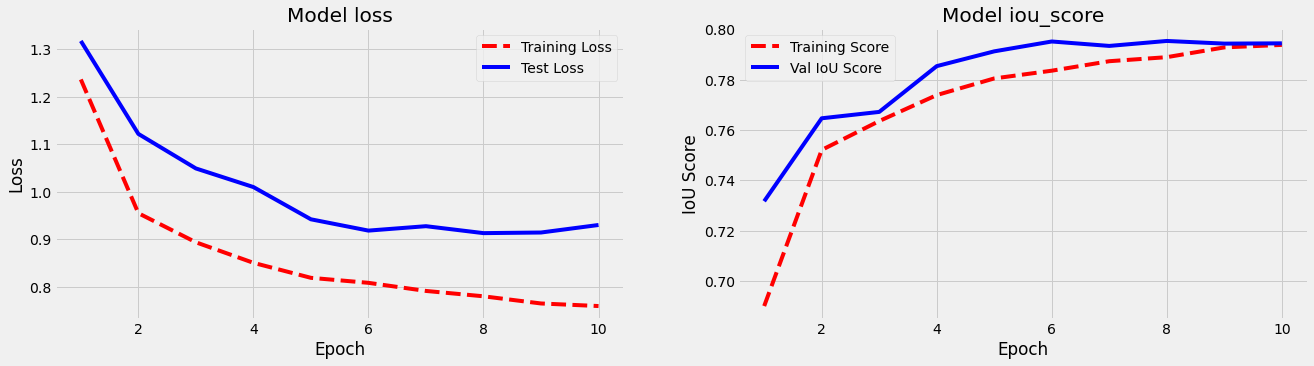

In [52]:
plt.figure(figsize=(20, 5))

plt.subplot(121)

# Get training and test loss histories
training_loss = result.history['loss']
test_loss = result.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.title('Model loss')

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Pylot iou-score 
plt.subplot(122)

# Get training and test loss histories
training_loss = result.history['iou_score']
test_loss = result.history['val_iou_score']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.title('Model iou_score')
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Score', 'Val IoU Score'])
plt.xlabel('Epoch')
plt.ylabel('IoU Score')

plt.show()



### Unfreeze layers

In [53]:
model = PSPNet(backbone_name='efficientnetb3',
                   input_shape=(144, 144, 3),
                   classes=4,
                   activation='softmax',
                   weights= './efficientnetb3_epoch-010_loss-0.7593_val_loss-0.9298.h5',
                   encoder_weights='imagenet',
                   encoder_freeze=False,
                   downsample_factor=8,
                   psp_conv_filters=512,
                   psp_pooling_type='avg',
                   psp_use_batchnorm=True,
                   psp_dropout=0.25)
for layer in model.layers:
    layer.trainable = True
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 72, 72, 40)   1080        input_16[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 72, 72, 40)   160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 72, 72, 40)   0           stem_bn[0][0]                    
___________________________________________________________________________________________

In [54]:
EPOCHS = 50 # Update Epochs
BATCH_SIZE = 8
steps_per_epoch = np.ceil(float(train_numbers) / float(BATCH_SIZE))
validation_steps = np.ceil(float(val_numbers) / float(BATCH_SIZE))
model.compile(optimizer=RMSprop(lr=0.0001), loss = combine_loss, metrics = [metrics])

result = model.fit_generator(TrainAugmentGenerator(batch_size=BATCH_SIZE), steps_per_epoch=steps_per_epoch,
                validation_data = ValAugmentGenerator(batch_size=BATCH_SIZE), 
                validation_steps = validation_steps, epochs=EPOCHS,callbacks=[model_checkpoint,early_stopping,reduce_learning_rate])

Found 3226 images belonging to 1 classes.
Found 3226 images belonging to 1 classes.
Epoch 1/50
404/404 [==============================] - ETA: 0s - loss: 0.7306 - iou_score: 0.8003 - f1-score: 0.8736 - precision: 0.8331 - recall: 0.9309Found 806 images belonging to 1 classes.
Found 806 images belonging to 1 classes.

Epoch 00001: saving model to ./efficientnetb3_epoch-001_loss-0.7306_val_loss-0.8424.h5
404/404 [==============================] - 122s 301ms/step - loss: 0.7306 - iou_score: 0.8003 - f1-score: 0.8736 - precision: 0.8331 - recall: 0.9309 - val_loss: 0.8424 - val_iou_score: 0.8093 - val_f1-score: 0.8766 - val_precision: 0.8995 - val_recall: 0.8618 - lr: 1.0000e-04
Epoch 2/50
404/404 [==============================] - ETA: 0s - loss: 0.7177 - iou_score: 0.8039 - f1-score: 0.8762 - precision: 0.8362 - recall: 0.9319
Epoch 00002: saving model to ./efficientnetb3_epoch-002_loss-0.7177_val_loss-0.7885.h5
404/404 [==============================] - 121s 299ms/step - loss: 0.7177 - 

Epoch 17/50
404/404 [==============================] - ETA: 0s - loss: 0.6113 - iou_score: 0.8313 - f1-score: 0.8969 - precision: 0.8596 - recall: 0.9449
Epoch 00017: saving model to ./efficientnetb3_epoch-017_loss-0.6113_val_loss-0.7295.h5
404/404 [==============================] - 121s 300ms/step - loss: 0.6113 - iou_score: 0.8313 - f1-score: 0.8969 - precision: 0.8596 - recall: 0.9449 - val_loss: 0.7295 - val_iou_score: 0.8365 - val_f1-score: 0.8964 - val_precision: 0.9100 - val_recall: 0.8907 - lr: 1.0000e-04
Epoch 18/50
403/404 [============================>.] - ETA: 0s - loss: 0.6091 - iou_score: 0.8318 - f1-score: 0.8971 - precision: 0.8599 - recall: 0.9447
Epoch 00018: saving model to ./efficientnetb3_epoch-018_loss-0.6091_val_loss-0.7454.h5
404/404 [==============================] - 120s 297ms/step - loss: 0.6091 - iou_score: 0.8319 - f1-score: 0.8971 - precision: 0.8599 - recall: 0.9448 - val_loss: 0.7454 - val_iou_score: 0.8332 - val_f1-score: 0.8943 - val_precision: 0.9300 

Epoch 33/50
404/404 [==============================] - ETA: 0s - loss: 0.5917 - iou_score: 0.8370 - f1-score: 0.9005 - precision: 0.8642 - recall: 0.9477
Epoch 00033: saving model to ./efficientnetb3_epoch-033_loss-0.5917_val_loss-0.6853.h5
404/404 [==============================] - 120s 298ms/step - loss: 0.5917 - iou_score: 0.8370 - f1-score: 0.9005 - precision: 0.8642 - recall: 0.9477 - val_loss: 0.6853 - val_iou_score: 0.8468 - val_f1-score: 0.9043 - val_precision: 0.9221 - val_recall: 0.8928 - lr: 2.0000e-05
Epoch 34/50
404/404 [==============================] - ETA: 0s - loss: 0.5850 - iou_score: 0.8387 - f1-score: 0.9021 - precision: 0.8660 - recall: 0.9480
Epoch 00034: saving model to ./efficientnetb3_epoch-034_loss-0.5850_val_loss-0.6960.h5
404/404 [==============================] - 120s 296ms/step - loss: 0.5850 - iou_score: 0.8387 - f1-score: 0.9021 - precision: 0.8660 - recall: 0.9480 - val_loss: 0.6960 - val_iou_score: 0.8451 - val_f1-score: 0.9031 - val_precision: 0.9250 

Epoch 49/50
404/404 [==============================] - ETA: 0s - loss: 0.5744 - iou_score: 0.8415 - f1-score: 0.9043 - precision: 0.8681 - recall: 0.9496
Epoch 00049: saving model to ./efficientnetb3_epoch-049_loss-0.5744_val_loss-0.6926.h5
404/404 [==============================] - 119s 295ms/step - loss: 0.5744 - iou_score: 0.8415 - f1-score: 0.9043 - precision: 0.8681 - recall: 0.9496 - val_loss: 0.6926 - val_iou_score: 0.8452 - val_f1-score: 0.9031 - val_precision: 0.9276 - val_recall: 0.8863 - lr: 1.0000e-05
Epoch 50/50
404/404 [==============================] - ETA: 0s - loss: 0.5777 - iou_score: 0.8403 - f1-score: 0.9033 - precision: 0.8670 - recall: 0.9490
Epoch 00050: saving model to ./efficientnetb3_epoch-050_loss-0.5777_val_loss-0.6866.h5
404/404 [==============================] - 118s 293ms/step - loss: 0.5777 - iou_score: 0.8403 - f1-score: 0.9033 - precision: 0.8670 - recall: 0.9490 - val_loss: 0.6866 - val_iou_score: 0.8462 - val_f1-score: 0.9037 - val_precision: 0.9257 

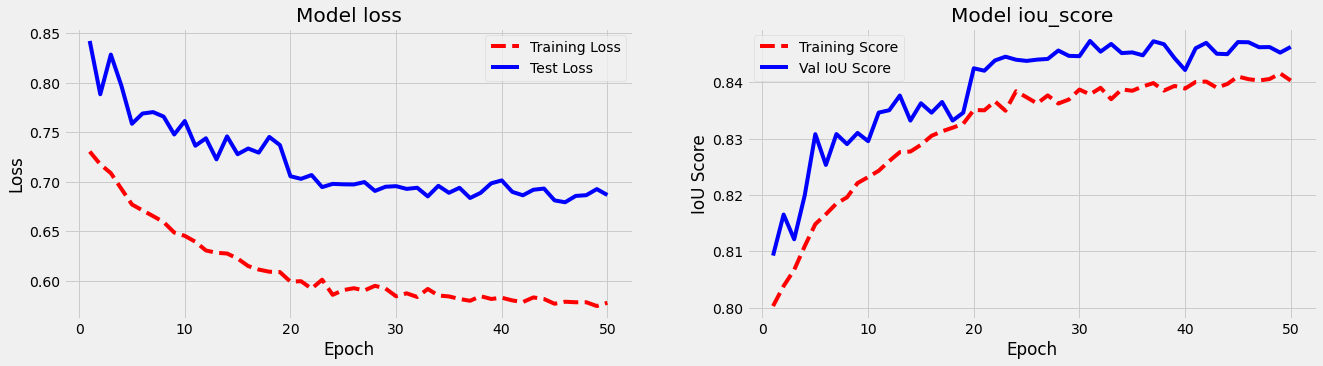

In [55]:
plt.figure(figsize=(20, 5))

plt.subplot(121)

# Get training and test loss histories
training_loss = result.history['loss']
test_loss = result.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.title('Model loss')

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Pylot iou-score 
plt.subplot(122)

# Get training and test loss histories
training_loss = result.history['iou_score']
test_loss = result.history['val_iou_score']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.title('Model iou_score')
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Score', 'Val IoU Score'])
plt.xlabel('Epoch')
plt.ylabel('IoU Score')

plt.show()

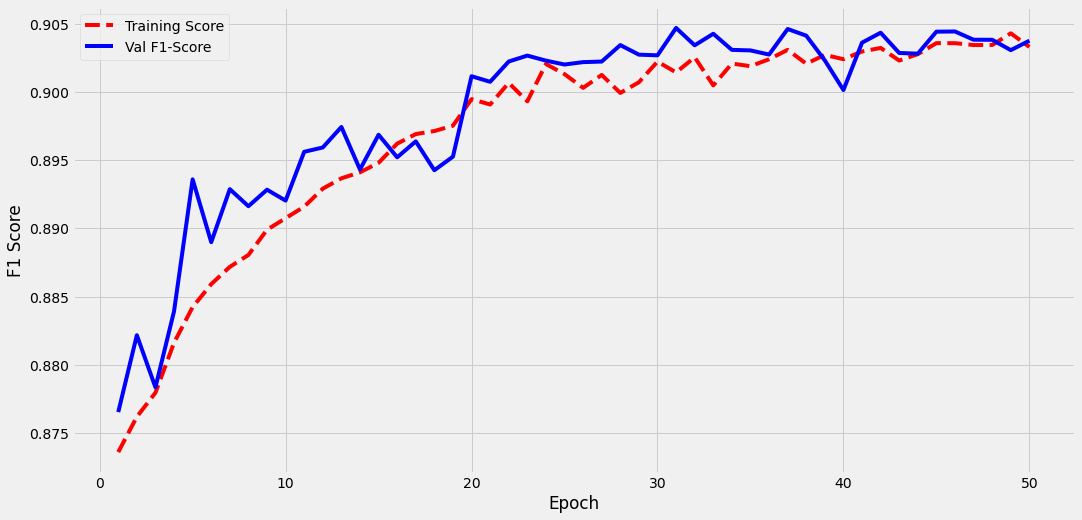

In [56]:
# Get training and test loss histories
training_loss = result.history['f1-score']
test_loss = result.history['val_f1-score']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Score', 'Val F1-Score'])
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.show()

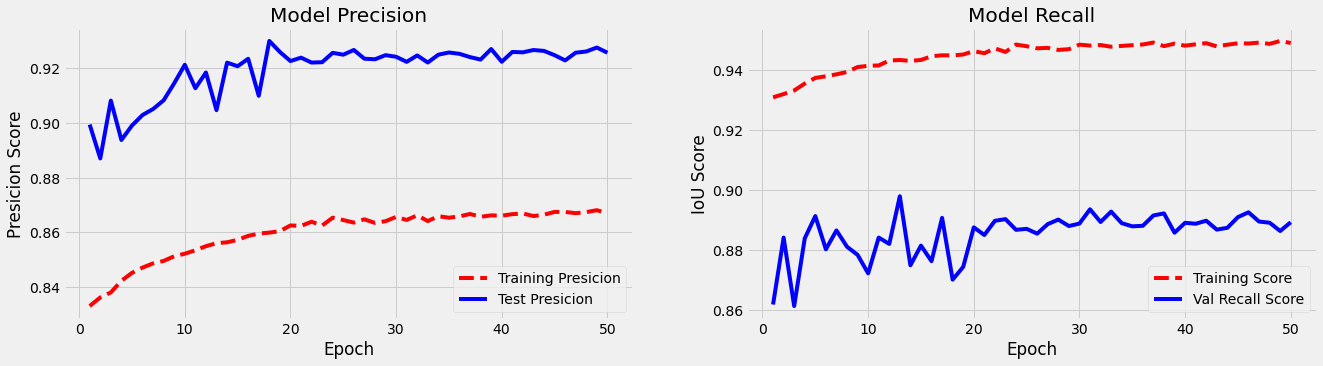

In [57]:
plt.figure(figsize=(20, 5))

plt.subplot(121)

# Get training and test loss histories
training_loss = result.history['precision']
test_loss = result.history['val_precision']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.title('Model Precision')

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Presicion', 'Test Presicion'])
plt.xlabel('Epoch')
plt.ylabel('Presicion Score')

# Pylot iou-score 
plt.subplot(122)

# Get training and test loss histories
training_loss = result.history['recall']
test_loss = result.history['val_recall']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.title('Model Recall')
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Score', 'Val Recall Score'])
plt.xlabel('Epoch')
plt.ylabel('IoU Score')

plt.show()

### Predict Video

In [58]:
model = PSPNet(backbone_name='efficientnetb3',
                   input_shape=(144, 144, 3),
                   classes=4,
                   activation='softmax',
                   weights= None,
                   encoder_weights='imagenet',
                   encoder_freeze=False,
                   downsample_factor=8,
                   psp_conv_filters=512,
                   psp_pooling_type='avg',
                   psp_use_batchnorm=True,
                   psp_dropout=0.25)

model.load_weights('./efficientnetb3_epoch-046_loss-0.5787_val_loss-0.6793.h5')

In [59]:
import cv2
import numpy as np
capture = cv2.VideoCapture('../input/videoo/Video_Beta.avi')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('./output_1607.avi',fourcc, 30.0, (144*2,144))
i=0
while(True):
    ret = capture.grab()
    #if i % 10 == 0:
        
    ret, frame = capture.retrieve()
    
    img = cv2.resize(frame,(144,144))
    img = (img[...,::-1].astype(np.float32)) / 255.0
    img = np.reshape(img, (1, 144, 144, 3))
    predict_one = model.predict(img)

    frame_real = cv2.resize(frame,(144,144))
    frame_pre = onehot_to_rgb(predict_one[0],id2code)

    frame_total = np.concatenate((frame_real, frame_pre), axis=1)
    
    i += 1
    print("Frame thu: ",i)
    #GG
    #cv2.imshow("Test",frame_total)
    #Save video
    out.write(frame_total)
    #cv2.imwrite('Frame_'+ str(i) +'.png',frame_total)
        # do something with frame
capture.release()

Frame thu:  1
Frame thu:  2
Frame thu:  3
Frame thu:  4
Frame thu:  5
Frame thu:  6
Frame thu:  7
Frame thu:  8
Frame thu:  9
Frame thu:  10
Frame thu:  11
Frame thu:  12
Frame thu:  13
Frame thu:  14
Frame thu:  15
Frame thu:  16
Frame thu:  17
Frame thu:  18
Frame thu:  19
Frame thu:  20
Frame thu:  21
Frame thu:  22
Frame thu:  23
Frame thu:  24
Frame thu:  25
Frame thu:  26
Frame thu:  27
Frame thu:  28
Frame thu:  29
Frame thu:  30
Frame thu:  31
Frame thu:  32
Frame thu:  33
Frame thu:  34
Frame thu:  35
Frame thu:  36
Frame thu:  37
Frame thu:  38
Frame thu:  39
Frame thu:  40
Frame thu:  41
Frame thu:  42
Frame thu:  43
Frame thu:  44
Frame thu:  45
Frame thu:  46
Frame thu:  47
Frame thu:  48
Frame thu:  49
Frame thu:  50
Frame thu:  51
Frame thu:  52
Frame thu:  53
Frame thu:  54
Frame thu:  55
Frame thu:  56
Frame thu:  57
Frame thu:  58
Frame thu:  59
Frame thu:  60
Frame thu:  61
Frame thu:  62
Frame thu:  63
Frame thu:  64
Frame thu:  65
Frame thu:  66
Frame thu:  67
Fram

Frame thu:  520
Frame thu:  521
Frame thu:  522
Frame thu:  523
Frame thu:  524
Frame thu:  525
Frame thu:  526
Frame thu:  527
Frame thu:  528
Frame thu:  529
Frame thu:  530
Frame thu:  531
Frame thu:  532
Frame thu:  533
Frame thu:  534
Frame thu:  535
Frame thu:  536
Frame thu:  537
Frame thu:  538
Frame thu:  539
Frame thu:  540
Frame thu:  541
Frame thu:  542
Frame thu:  543
Frame thu:  544
Frame thu:  545
Frame thu:  546
Frame thu:  547
Frame thu:  548
Frame thu:  549
Frame thu:  550
Frame thu:  551
Frame thu:  552
Frame thu:  553
Frame thu:  554
Frame thu:  555
Frame thu:  556
Frame thu:  557
Frame thu:  558
Frame thu:  559
Frame thu:  560
Frame thu:  561
Frame thu:  562
Frame thu:  563
Frame thu:  564
Frame thu:  565
Frame thu:  566
Frame thu:  567
Frame thu:  568
Frame thu:  569
Frame thu:  570
Frame thu:  571
Frame thu:  572
Frame thu:  573
Frame thu:  574
Frame thu:  575
Frame thu:  576
Frame thu:  577
Frame thu:  578
Frame thu:  579
Frame thu:  580
Frame thu:  581
Frame th

Frame thu:  1037
Frame thu:  1038
Frame thu:  1039
Frame thu:  1040
Frame thu:  1041
Frame thu:  1042
Frame thu:  1043
Frame thu:  1044
Frame thu:  1045
Frame thu:  1046
Frame thu:  1047
Frame thu:  1048
Frame thu:  1049
Frame thu:  1050
Frame thu:  1051
Frame thu:  1052
Frame thu:  1053
Frame thu:  1054
Frame thu:  1055
Frame thu:  1056
Frame thu:  1057
Frame thu:  1058
Frame thu:  1059
Frame thu:  1060
Frame thu:  1061
Frame thu:  1062
Frame thu:  1063
Frame thu:  1064
Frame thu:  1065
Frame thu:  1066
Frame thu:  1067
Frame thu:  1068
Frame thu:  1069
Frame thu:  1070
Frame thu:  1071
Frame thu:  1072
Frame thu:  1073
Frame thu:  1074
Frame thu:  1075
Frame thu:  1076
Frame thu:  1077
Frame thu:  1078
Frame thu:  1079
Frame thu:  1080
Frame thu:  1081
Frame thu:  1082
Frame thu:  1083
Frame thu:  1084
Frame thu:  1085
Frame thu:  1086
Frame thu:  1087
Frame thu:  1088
Frame thu:  1089
Frame thu:  1090
Frame thu:  1091
Frame thu:  1092
Frame thu:  1093
Frame thu:  1094
Frame thu:  10

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


### Convert model to .pb frozen graph 

In [ ]:
from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph
    
model.load_weights('/home/dylan/Desktop/Goodgame_Training/model/Model_4_class_Test_1_epoch-175_loss-0.7673_val_loss-0.7632.h5')

frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, "model_pb", "Model_4_class_Test_1_epoch-175_loss-0.7673_val_loss-0.7632.pb", as_text=False)

print("Input Model:  ",model.inputs)
print("Output Model:  ",model.outputs)

### Read image

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))

img = cv2.imread('../input/weqweqweqweqweqweqweqwe/goodgame_raw_5138.png')
img = cv2.resize(img,(144,144))
plt.subplot(1,2,1)
plt.imshow(img)
lower = np.array([0, 0, 180])
upper = np.array([180, 255, 255])
# Create HSV Image and threshold into a range.
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lower, upper)
line_opencv = mask[:,:] # We want to get half of image below
#print(line_opencv.shape)
plt.subplot(1,2,2)
plt.imshow(line_opencv)

In [ ]:
for i in range(0,144):
    for j in range(0,144):
        if line_opencv[i][j] == 255:
            img[i][j] = 255
            #print(img[i][j])
plt.imshow(img)